# Spelling Correction using Deep Learning

Inspired by https://medium.com/@majortal/deep-spelling-9ffef96a24f6. Code can be found at https://github.com/MajorTal/DeepSpell/blob/master/keras_spell.py.

**Character Sequence to Sequence** code pulled from https://github.com/mdcramer/deep-learning/tree/master/seq2seq.

Environment initialization:
* open Acaconda terminal
* run ">activate tensorflow"
* run ">jupyter notebook"

"I see that you have made three spelling mistakes." - Marquis de Favras, purportedly, upon the reading of his death warrant prior to be hanged in 1790.
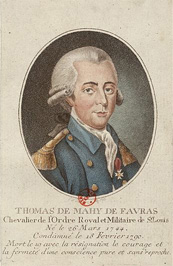

# Initialize global variables
**Make sure to run this cell first each time**

In [1]:
# These filesname are loaded here since they're used after the graph has been saved
GRAPH_PARAMETERS = "graph_params" # Filename for storing parameters associated with the graph
SOURCE_INT_TO_LETTER = "sourceinttoletter.json" # Filename for storing INT to letter List for source sentences
TARGET_INT_TO_LETTER = "targetinttoletter.json" # Filename for storing INT to letter List for target sentences
SOURCE_LETTER_TO_INT = "sourcelettertoint.json" # Filename for storing letter to INT List for source sentences

# This is where the graph is going to be saved and reloaded
checkpoint = "./best_model.ckpt"

## Download raw data file from the internet and uncompress it

[One Billion Word Benchmark for Measuring Progress in Statistical Language Modeling](https://research.google.com/pubs/pub41880.html)

**Start here if you are going to work with the big dataset** The dataset lives in the /data/ folder.

**Skip to below to work with the small dataset**

In [1]:
import os
import errno
import requests
import gzip

NEWS_FILE_NAME_COMPRESSED = os.path.join(os.path.expanduser("data"), "news.2013.en.shuffled.gz") # 1.1 GB file
DATA_FILES_URL = "http://www.statmt.org/wmt14/training-monolingual-news-crawl/news.2013.en.shuffled.gz" # file location

# create directory for data, if it does not already exist
try:
    os.makedirs(os.path.dirname(NEWS_FILE_NAME_COMPRESSED))
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

# check size of current data file
try:
    current_size = os.path.getsize(NEWS_FILE_NAME_COMPRESSED)
except:
    current_size = 0

# check size of data file on internet
response = requests.get(DATA_FILES_URL, stream=True)
total_length = response.headers.get('content-length') # returns a str
total_length = int(total_length)
    
# download file if it is larger than the one already in the data directory
if (total_length > current_size):
    print("Download compressed data file")
    with open(NEWS_FILE_NAME_COMPRESSED, "wb") as output_file: # open for writing in binary mode
        downloaded = percentage = 0
        print("»"*100)
        for data in response.iter_content(chunk_size=4096):
            downloaded += len(data)
            output_file.write(data)
            new_percentage = 100 * downloaded // total_length # // is floor divide
            if new_percentage > percentage:
                print("o", end="") # end="" remove carriage return
                percentage = new_percentage
    print() # add carriage return at the end of progress indicator
else:
    print("Local copy of compressed data file is up to date.")
    
# uncompress data
if (os.path.isfile(NEWS_FILE_NAME_COMPRESSED[:-3])): # check to see if file already exists
    print("Data file is already uncompressed.")
else:
    print("Uncompress data file.") # uncompress the file if it does not
    with gzip.open(NEWS_FILE_NAME_COMPRESSED, 'rb') as compressed_file:
        with open(NEWS_FILE_NAME_COMPRESSED[:-3], 'wb') as outfile: #2.5 GB file
            outfile.write(compressed_file.read())
    print("Data file uncompressed.")

Local copy of compressed data file is up to date.
Data file is already uncompressed.


## Clean the data

In [2]:
import re

NEWS_FILE_NAME_CLEAN = os.path.join(os.path.expanduser("data"), "news.2013.en.clean") # clean data file
NEWS_FILE_NAME = os.path.join(os.path.expanduser("data"), "news.2013.en.shuffled") # uncompressed data file

NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE) # match all whitespace except newlines
RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'
                                  .format(chr(768), chr(769), chr(832), chr(833), chr(2387),
                                          chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
ALLOWED_CURRENCIES = """¥£₪$€฿₨"""
ALLOWED_PUNCTUATION = """-!?/;"'%&<>.()[]{}@#:,|=*"""
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}{}]'
                              .format(re.escape(ALLOWED_CURRENCIES), re.escape(ALLOWED_PUNCTUATION)), re.UNICODE)

def file_len(fname):
    with open(fname, encoding="utf8") as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def clean_text(text):
    # Clean the text - remove unwanted chars, fold punctuation etc.
    result = NORMALIZE_WHITESPACE_REGEX.sub(' ', text.strip())
    result = RE_DASH_FILTER.sub('-', result)
    result = RE_APOSTROPHE_FILTER.sub("'", result)
    result = RE_LEFT_PARENTH_FILTER.sub("(", result)
    result = RE_RIGHT_PARENTH_FILTER.sub(")", result)
    result = RE_BASIC_CLEANER.sub('', result)
    return result

if (os.path.isfile(NEWS_FILE_NAME_CLEAN)):
    print("Data file is already clean.")
else:    
    print("Clean data file:")
    number_lines = file_len(NEWS_FILE_NAME)
    with open(NEWS_FILE_NAME_CLEAN, "wb") as clean_data:
        processed = percentage = 0
        for line in open(NEWS_FILE_NAME, encoding="utf8"):
            processed += 1
            # decoded_line = line.decode('utf-8') # https://stackoverflow.com/a/28583969/852795
            cleaned_line = clean_text(line)
            encoded_line = cleaned_line.encode("utf-8")
            clean_data.write(encoded_line + b"\n")
            new_percentage = 100 * processed // number_lines
            if (new_percentage > percentage):
                print("{0:2d}".format(new_percentage), "%: ", line, end="")
                percentage = new_percentage

Data file is already clean.


## Analyze the charaters

Get counts of all of the characters and select the top ones for processing and filter only sentences with the right charcters. Eliminate any sentences that are too small or too long.

In [4]:
from collections import Counter
import json

NUMBER_OF_CHARS = 100 # quantity of most popular characters to keep
CHAR_FREQUENCY_FILE_NAME = os.path.join(os.path.expanduser("data"), "news.2013.en.char_frequency.json")
NEWS_FILE_NAME_FILTERED = os.path.join(os.path.expanduser("data"), "news.2013.en.filtered")
MIN_INPUT_LEN = 5 # minimum number of characters in a sentence
MAX_INPUT_LEN = 60 # maximum number of characters in a sentence

# create character frequency file
if (os.path.isfile(CHAR_FREQUENCY_FILE_NAME)):
    print("Character frequency file already created.")
else:
    counter = Counter()
    print("Reading data file:")
    for line in open(NEWS_FILE_NAME_CLEAN, encoding="utf8"):
        counter.update(line)
    print("Done. Writing to file:")
    with open(CHAR_FREQUENCY_FILE_NAME, 'wb') as output_file:
        output_file.write(json.dumps(counter).encode("utf-8"))
    most_popular_chars = {key for key, _value in counter.most_common(NUMBER_OF_CHARS)}
    
# read top characters that were saved to file
chars = json.loads(open(CHAR_FREQUENCY_FILE_NAME).read())
counter = Counter(chars)
most_popular_chars = {key for key, _value in counter.most_common(NUMBER_OF_CHARS)}
print("The top %s chars are:", NUMBER_OF_CHARS)
print("".join(sorted(most_popular_chars)))

# filter only sentences with the right chars
if (os.path.isfile(NEWS_FILE_NAME_FILTERED)):
    print("\nFiltered file already created.")
else:
    print("\nReading and filtering data:")
    num_lines = 0
    with open(NEWS_FILE_NAME_FILTERED, "wb") as output_file:
        for line in open(NEWS_FILE_NAME_CLEAN, encoding="utf8"):
            if line and (not bool(set(line) - most_popular_chars)) and (MAX_INPUT_LEN >= len(line) > MIN_INPUT_LEN):
                output_file.write(line.encode("utf8"))
                num_lines += 1
                if (num_lines % 1000000 == 0):
                    print("{0:10,d}".format(num_lines), ": ", line, end="")
    print("Done. Filtered file contains {:,} lines.".format(num_lines))

Reading data file:
Done. Writing to file:
The top %s chars are: 100

 !"#$%&'()*,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz£àáâçèéêíîïôùûü€

Reading and filtering data:
 1,000,000 :  Our Tip: 7th
 2,000,000 :  Premier League: West Ham v Cardiff match preview
 3,000,000 :  NCAA Penalizes Montana Football Over Booster Perks
 4,000,000 :  Now it's living standards, stupid.
Done. Filtered file contains 4,799,651 lines.


## Split the data into training and validation sets

In [5]:
from numpy.random import shuffle as random_shuffle

NEWS_FILE_NAME_TRAIN = os.path.join(os.path.expanduser("data"), "news.2013.en.train")
NEWS_FILE_NAME_VALIDATE = os.path.join(os.path.expanduser("data"), "news.2013.en.validate")

if (os.path.isfile(NEWS_FILE_NAME_TRAIN)):
    print("Training and Validation files already created.")
else:
    answers = open(NEWS_FILE_NAME_FILTERED, encoding="utf8").read().split("\n")
    print('shuffle', end=" ")
    random_shuffle(answers)
    print("Done")
    # Explicitly set apart 10% for validation data that we never train over
    # TODO skip if files already exist
    split_at = len(answers) - len(answers) // 10
    with open(NEWS_FILE_NAME_TRAIN, "wb") as output_file:
        output_file.write("\n".join(answers[:split_at]).encode('utf-8'))
    with open(NEWS_FILE_NAME_VALIDATE, "wb") as output_file:
        output_file.write("\n".join(answers[split_at:]).encode('utf-8'))
    print("\nTraining and Validation files written.")

shuffle Done


## Load the target data and generate source data by injecting mistakes

In [6]:
AMOUNT_OF_NOISE = 0.2 / MAX_INPUT_LEN

from numpy.random import choice as random_choice, randint as random_randint, seed as random_seed, rand

def add_noise_to_string(a_string, amount_of_noise): # Add some artificial spelling mistakes to the string
    
    CHARS = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .")

    if rand() < amount_of_noise * len(a_string):
        # Replace a character with a random character
        random_char_position = random_randint(len(a_string))
        a_string = a_string[:random_char_position] + random_choice(CHARS[:-1]) + a_string[random_char_position + 1:]
    if rand() < amount_of_noise * len(a_string):
        # Delete a character
        random_char_position = random_randint(len(a_string))
        a_string = a_string[:random_char_position] + a_string[random_char_position + 1:]
    if len(a_string) < MAX_INPUT_LEN and rand() < amount_of_noise * len(a_string):
        # Add a random character
        random_char_position = random_randint(len(a_string))
        a_string = a_string[:random_char_position] + random_choice(CHARS[:-1]) + a_string[random_char_position:]
    if rand() < amount_of_noise * len(a_string):
        # Transpose 2 characters
        random_char_position = random_randint(len(a_string) - 1)
        a_string = (a_string[:random_char_position] + a_string[random_char_position + 1] + 
                    a_string[random_char_position] + a_string[random_char_position + 2:])
    return a_string

target_sentences = open(NEWS_FILE_NAME_TRAIN, encoding="utf8").read().split("\n")    
source_sentences = open(NEWS_FILE_NAME_TRAIN, encoding="utf8").read().split("\n")
for i in range(len(source_sentences)):
    source_sentences[i] = add_noise_to_string(source_sentences[i], AMOUNT_OF_NOISE)

print('\nFirst 10 sentence:')
for i in range (0, 10):
    print("\nSource --> " + source_sentences[i])
    print("Target --> " + target_sentences[i])


First 10 sentence:

Source --> The leaidng ladies hat impacted on Sir David's life
Target --> The leading ladies that impacted on Sir David's life

Source --> They resigned from the Party.
Target --> They resigned from the Party.

Source --> Everything he went for today went for six or four.
Target --> Everything he went for today went for six or four.

Source --> Hannon St., 1600 block, 4:33 p.m.
Target --> Hannon St., 1600 block, 4:33 p.m.

Source --> Because they're holy places.
Target --> Because they're holy places.

Source --> The next person would have the lighter," he says.
Target --> The next person would have the lighter," he says.

Source --> The acquittal of Rabei Osman is also upheld.
Target --> The acquittal of Rabei Osman is also upheld.

Source --> "But I'll tell you what," he added.
Target --> "But I'll tell you what," he added.

Source --> It can't make a profit from Kwhat it's got already.
Target --> It can't make a profit from what it's got already.

Source --> The

## Dataset
Take a look at the initial source and target datasets.

In [7]:
print("The source is comprised of {:,} sentences. Here are the first 10.".format(len(source_sentences)))
source_sentences[:10]

The source is comprised of 4,319,687 sentences. Here are the first 10.


["The leaidng ladies hat impacted on Sir David's life",
 'They resigned from the Party.',
 'Everything he went for today went for six or four.',
 'Hannon St., 1600 block, 4:33 p.m.',
 "Because they're holy places.",
 'The next person would have the lighter," he says.',
 'The acquittal of Rabei Osman is also upheld.',
 '"But I\'ll tell you what," he added.',
 "It can't make a profit from Kwhat it's got already.",
 'The results were largeyl the same.']

In [8]:
print("The target is comprised of {:,} sentences. Here are the first 10.".format(len(target_sentences)))
target_sentences[:10]

The target is comprised of 4,319,687 sentences. Here are the first 10.


["The leading ladies that impacted on Sir David's life",
 'They resigned from the Party.',
 'Everything he went for today went for six or four.',
 'Hannon St., 1600 block, 4:33 p.m.',
 "Because they're holy places.",
 'The next person would have the lighter," he says.',
 'The acquittal of Rabei Osman is also upheld.',
 '"But I\'ll tell you what," he added.',
 "It can't make a profit from what it's got already.",
 'The results were largely the same.']

## <font color='red'>Only run this cell to get the tiny data set</font>
**Start here if you are going to run with the small dataset** If you are using the big dataset, make sure to skip this.

In [7]:
# Run this cell to grab the small data sets that came with this model. Otherwise skip it.
# The dataset lives in the /data/ folder. At the moment, it is made up of the following files:
# letters_source.txt: The list of input letter sequences. Each sequence is its own line. 
# letters_target.txt: The list of target sequences we'll use in the training process.
# Each sequence here is a response to the input sequence in letters_source.txt with the same line number.

import helper

source_path = 'data/letters_source.txt'
target_path = 'data/letters_target.txt'

source_sentences = helper.load_data(source_path).split('\n') # added .split('\n) to be consistent with big data
target_sentences = helper.load_data(target_path).split('\n')

# source_sentences contains the entire input sequence file as text delimited by newline symbols.
print("Source: {}".format(source_sentences[:10]))
# target_sentences contains the entire output sequence file as text delimited by newline symbols.
# Each line corresponds to the line from source_sentences. target_sentences contains a sorted characters of the line.
print("Target: {}".format(target_sentences[:10]))

print("\nThe source is comprised of {:,} sentences.".format(len(source_sentences)))

Source: ['bsaqq', 'npy', 'lbwuj', 'bqv', 'kial', 'tddam', 'edxpjpg', 'nspv', 'huloz', 'kmclq']
Target: ['abqqs', 'npy', 'bjluw', 'bqv', 'aikl', 'addmt', 'degjppx', 'npsv', 'hlouz', 'cklmq']

The source is comprised of 10,000 sentences.


## Preprocess
To do anything useful with it, turn the each string into a list of characters. Then convert the characters to their int values as declared in the vocabulary.

In [8]:
import json

def extract_character_vocab(data):
    special_words = ['<PAD>', '<UNK>', '<GO>',  '<EOS>']

    #set_words = set([character for line in data.split('\n') for character in line])
    set_words = set([character for line in data for character in line])
    int_to_vocab = {word_i: word for word_i, word in enumerate(special_words + list(set_words))}
    vocab_to_int = {word: word_i for word_i, word in int_to_vocab.items()}

    return int_to_vocab, vocab_to_int

# Build int2letter and letter2int dicts
source_int_to_letter, source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter, target_letter_to_int = extract_character_vocab(target_sentences)
print("Source INT to letter: {}".format(source_int_to_letter))
print("Target INT to letter: {}\n".format(target_int_to_letter))

# Save source_int_to_letter, target_int_to_letter & source_letter_to_int for loading later after graph is saved
with open(SOURCE_INT_TO_LETTER, 'w') as output_file:
    json.dump(source_int_to_letter, output_file)
print("Wrote source_int_to_letter data to file.")
with open(TARGET_INT_TO_LETTER, 'w') as output_file:
    json.dump(target_int_to_letter, output_file)
print("Wrote target_int_to_letter data to file.")
with open(SOURCE_LETTER_TO_INT, 'w') as output_file:
    json.dump(source_letter_to_int, output_file)
print("Wrote source_letter_to_int data to file.\n")

# Convert characters to ids
#source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<UNK>']) for letter in line] for line in source_sentences.split('\n')]
#target_letter_ids = [[target_letter_to_int.get(letter, target_letter_to_int['<UNK>']) for letter in line] + [target_letter_to_int['<EOS>']] for line in target_sentences.split('\n')] 
source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<UNK>']) for letter in line] for line in source_sentences]
target_letter_ids = [[target_letter_to_int.get(letter, target_letter_to_int['<UNK>']) for letter in line] + [target_letter_to_int['<EOS>']] for line in target_sentences]

print("Example source sequence")
print(source_letter_ids[:3])
print("\nExample target sequence")
print(target_letter_ids[:3])

Source INT to letter: {0: '<PAD>', 1: '<UNK>', 2: '<GO>', 3: '<EOS>', 4: 'g', 5: 'x', 6: 'z', 7: 'm', 8: 'u', 9: 'c', 10: 'a', 11: 's', 12: 'r', 13: 'i', 14: 'l', 15: 'f', 16: 'p', 17: 'o', 18: 'n', 19: 'h', 20: 'y', 21: 'v', 22: 'w', 23: 'k', 24: 'd', 25: 't', 26: 'e', 27: 'b', 28: 'j', 29: 'q'}
Target INT to letter: {0: '<PAD>', 1: '<UNK>', 2: '<GO>', 3: '<EOS>', 4: 'g', 5: 'x', 6: 'z', 7: 'm', 8: 'u', 9: 'c', 10: 'a', 11: 's', 12: 'r', 13: 'i', 14: 'l', 15: 'f', 16: 'p', 17: 'o', 18: 'n', 19: 'h', 20: 'y', 21: 'v', 22: 'w', 23: 'k', 24: 'd', 25: 't', 26: 'e', 27: 'b', 28: 'j', 29: 'q'}

Wrote source_int_to_letter data to file.
Wrote target_int_to_letter data to file.
Wrote source_letter_to_int data to file.

Example source sequence
[[27, 11, 10, 29, 29], [18, 16, 20], [14, 27, 22, 8, 28]]

Example target sequence
[[10, 27, 29, 29, 11, 3], [18, 16, 20, 3], [27, 28, 14, 8, 22, 3]]


In [9]:
print('\nFirst 10 sentence:')
for i in range (0, 10):
    print("\nSource --> {}".format(source_letter_ids[i]))
    print("Target --> {}".format(target_letter_ids[i]))


First 10 sentence:

Source --> [27, 11, 10, 29, 29]
Target --> [10, 27, 29, 29, 11, 3]

Source --> [18, 16, 20]
Target --> [18, 16, 20, 3]

Source --> [14, 27, 22, 8, 28]
Target --> [27, 28, 14, 8, 22, 3]

Source --> [27, 29, 21]
Target --> [27, 29, 21, 3]

Source --> [23, 13, 10, 14]
Target --> [10, 13, 23, 14, 3]

Source --> [25, 24, 24, 10, 7]
Target --> [10, 24, 24, 7, 25, 3]

Source --> [26, 24, 5, 16, 28, 16, 4]
Target --> [24, 26, 4, 28, 16, 16, 5, 3]

Source --> [18, 11, 16, 21]
Target --> [18, 16, 11, 21, 3]

Source --> [19, 8, 14, 17, 6]
Target --> [19, 14, 17, 8, 6, 3]

Source --> [23, 7, 9, 14, 29]
Target --> [9, 23, 14, 7, 29, 3]


## Character Sequence to Sequence Model
This model was updated to work with TensorFlow 1.1 and builds on the work of Dave Currie. Check out Dave's post [Text Summarization with Amazon Reviews](https://medium.com/towards-data-science/text-summarization-with-amazon-reviews-41801c2210b).
<img src="images/sequence-to-sequence.jpg"/>
#### Check the Version of TensorFlow and wether or not there's a GPU

In [10]:
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Hyperparameters

In [11]:
if (len(source_sentences) > 10000):
    
    # We are using the big data
    print("Using hyperparameters for the big data with {:,} source sentences.".format(len(source_sentences)))
    epochs = 1       # Number of Epochs
    batch_size = 128 # Batch Size

    rnn_size = 512   # RNN Size
    num_layers = 2   # Number of Layers
    encoding_embedding_size = 256 # Encoding embedding Size
    decoding_embedding_size = 256 # Decoding embedding Size

    learning_rate = 0.001 # Learning Rate
    
else:
    
    # We are using the small data
    print("Using hyperparameters for the small data with {:,} source sentences.".format(len(source_sentences)))
    epochs = 60 # Number of Epochs
    batch_size = 128 # Batch Size
    rnn_size = 50 # RNN Size    
    num_layers = 2 # Number of Layers    
    encoding_embedding_size = 15 # Embedding Size
    decoding_embedding_size = 15 # Embedding Size    
    learning_rate = 0.001 # Learning Rate
    
# Write batch_size to file for loading after graph has been saved
with open(GRAPH_PARAMETERS, 'w') as file:
  file.write('%d' % batch_size)

Using hyperparameters for the small data with 10,000 source sentences.


### Input

In [12]:
def get_model_inputs():
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
    max_target_sequence_length = tf.reduce_max(target_sequence_length, name='max_target_len')
    source_sequence_length = tf.placeholder(tf.int32, (None,), name='source_sequence_length')
    
    return input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length

### Sequence to Sequence Model

We can now start defining the functions that will build the seq2seq model. We are building it from the bottom up with the following components:

    2.1 Encoder
        - Embedding
        - Encoder cell
    2.2 Decoder
        1- Process decoder inputs
        2- Set up the decoder
            - Embedding
            - Decoder cell
            - Dense output layer
            - Training decoder
            - Inference decoder
    2.3 Seq2seq model connecting the encoder and decoder
    2.4 Build the training graph hooking up the model with the 
        optimizer



### 2.1 Encoder

The first bit of the model we'll build is the encoder. Here, we'll embed the input data, construct our encoder, then pass the embedded data to the encoder.

- Embed the input data using [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)
<img src="images/embed_sequence.png" />

- Pass the embedded input into a stack of RNNs.  Save the RNN state and ignore the output.
<img src="images/encoder.png" />

In [13]:
def encoding_layer(input_data, rnn_size, num_layers,
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):


    # Encoder embedding
    enc_embed_input = tf.contrib.layers.embed_sequence(input_data, source_vocab_size, encoding_embedding_size)

    # RNN cell
    def make_cell(rnn_size):
        enc_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return enc_cell

    enc_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    
    enc_output, enc_state = tf.nn.dynamic_rnn(enc_cell, enc_embed_input, sequence_length=source_sequence_length, dtype=tf.float32)
    
    return enc_output, enc_state

## 2.2 Decoder

The decoder is probably the most involved part of this model. The following steps are needed to create it:

    1- Process decoder inputs
    2- Set up the decoder components
        - Embedding
        - Decoder cell
        - Dense output layer
        - Training decoder
        - Inference decoder


### Process Decoder Input


In the training process, the target sequences will be used in two different places:

 1. Using them to calculate the loss
 2. Feeding them to the decoder during training to make the model more robust.

Now we need to address the second point. Let's assume our targets look like this in their letter/word form (we're doing this for readibility. At this point in the code, these sequences would be in int form):


<img src="images/targets_1.png"/>

We need to do a simple transformation on the tensor before feeding it to the decoder:

1- We will feed an item of the sequence to the decoder at each time step. Think about the last timestep -- where the decoder outputs the final word in its output. The input to that step is the item before last from the target sequence. The decoder has no use for the last item in the target sequence in this scenario. So we'll need to remove the last item. 

We do that using tensorflow's tf.strided_slice() method. We hand it the tensor, and the index of where to start and where to end the cutting.

<img src="images/strided_slice_1.png"/>

2- The first item in each sequence we feed to the decoder has to be GO symbol. So We'll add that to the beginning.


<img src="images/targets_add_go.png"/>


Now the tensor is ready to be fed to the decoder. It looks like this (if we convert from ints to letters/symbols):

<img src="images/targets_after_processing_1.png"/>

In [14]:
# Process the input we'll feed to the decoder
def process_decoder_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input


### Set up the decoder components

        - Embedding
        - Decoder cell
        - Dense output layer
        - Training decoder
        - Inference decoder

#### 1- Embedding
Now that we have prepared the inputs to the training decoder, we need to embed them so they can be ready to be passed to the decoder. 

We'll create an embedding matrix like the following then have tf.nn.embedding_lookup convert our input to its embedded equivalent:
<img src="images/embeddings.png" />

#### 2- Decoder Cell
Then we declare our decoder cell. Just like the encoder, we'll use an tf.contrib.rnn.LSTMCell here as well.

We need to declare a decoder for the training process, and a decoder for the inference/prediction process. These two decoders will share their parameters (so that all the weights and biases that are set during the training phase can be used when we deploy the model).

First, we'll need to define the type of cell we'll be using for our decoder RNNs. We opted for LSTM.

#### 3- Dense output layer
Before we move to declaring our decoders, we'll need to create the output layer, which will be a tensorflow.python.layers.core.Dense layer that translates the outputs of the decoder to logits that tell us which element of the decoder vocabulary the decoder is choosing to output at each time step.

#### 4- Training decoder
Essentially, we'll be creating two decoders which share their parameters. One for training and one for inference. The two are similar in that both created using tf.contrib.seq2seq.**BasicDecoder** and tf.contrib.seq2seq.**dynamic_decode**. They differ, however, in that we feed the the target sequences as inputs to the training decoder at each time step to make it more robust.

We can think of the training decoder as looking like this (except that it works with sequences in batches):
<img src="images/sequence-to-sequence-training-decoder.png"/>

The training decoder **does not** feed the output of each time step to the next. Rather, the inputs to the decoder time steps are the target sequence from the training dataset (the orange letters).

#### 5- Inference decoder
The inference decoder is the one we'll use when we deploy our model to the wild.

<img src="images/sequence-to-sequence-inference-decoder.png"/>

We'll hand our encoder hidden state to both the training and inference decoders and have it process its output. TensorFlow handles most of the logic for us. We just have to use the appropriate methods from tf.contrib.seq2seq and supply them with the appropriate inputs.


In [15]:
def decoding_layer(target_letter_to_int, decoding_embedding_size, num_layers, rnn_size,
                   target_sequence_length, max_target_sequence_length, enc_state, dec_input):
    # 1. Decoder Embedding
    target_vocab_size = len(target_letter_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)

    # 2. Construct the decoder cell
    def make_cell(rnn_size):
        dec_cell = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
        return dec_cell

    dec_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
     
    # 3. Dense layer to translate the decoder's output at each time 
    # step into a choice from the target vocabulary
    output_layer = Dense(target_vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))


    # 4. Set up a training decoder and an inference decoder
    # Training Decoder
    with tf.variable_scope("decode"):

        # Helper for the training process. Used by BasicDecoder to read inputs.
        training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                            sequence_length=target_sequence_length,
                                                            time_major=False)
        
        
        # Basic decoder
        training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                           training_helper,
                                                           enc_state,
                                                           output_layer) 
        
        # Perform dynamic decoding using the decoder
        training_decoder_output = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                                       impute_finished=True,
                                                                       maximum_iterations=max_target_sequence_length)[0]
    # 5. Inference Decoder
    # Reuses the same parameters trained by the training process
    with tf.variable_scope("decode", reuse=True):
        start_tokens = tf.tile(tf.constant([target_letter_to_int['<GO>']], dtype=tf.int32), [batch_size], name='start_tokens')

        # Helper for the inference process.
        inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings,
                                                                start_tokens,
                                                                target_letter_to_int['<EOS>'])

        # Basic decoder
        inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        enc_state,
                                                        output_layer)
        
        # Perform dynamic decoding using the decoder
        inference_decoder_output = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                            impute_finished=True,
                                                            maximum_iterations=max_target_sequence_length)[0]
         

    
    return training_decoder_output, inference_decoder_output

## 2.3 Seq2seq model 
Let's now go a step above, and hook up the encoder and decoder using the methods we just declared

In [16]:
def seq2seq_model(input_data, targets, lr, target_sequence_length, 
                  max_target_sequence_length, source_sequence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size, 
                  rnn_size, num_layers):
    
    # Pass the input data through the encoder. We'll ignore the encoder output, but use the state
    _, enc_state = encoding_layer(input_data, 
                                  rnn_size, 
                                  num_layers, 
                                  source_sequence_length,
                                  source_vocab_size, 
                                  encoding_embedding_size)
    
    
    # Prepare the target sequences we'll feed to the decoder in training mode
    dec_input = process_decoder_input(targets, target_letter_to_int, batch_size)
    
    # Pass encoder state and decoder inputs to the decoders
    training_decoder_output, inference_decoder_output = decoding_layer(target_letter_to_int, 
                                                                       decoding_embedding_size, 
                                                                       num_layers, 
                                                                       rnn_size,
                                                                       target_sequence_length,
                                                                       max_target_sequence_length,
                                                                       enc_state, 
                                                                       dec_input) 
    
    return training_decoder_output, inference_decoder_output
    



Model outputs *training_decoder_output* and *inference_decoder_output* both contain a 'rnn_output' logits tensor that looks like this:

<img src="images/logits.png"/>

The logits we get from the training tensor we'll pass to tf.contrib.seq2seq.**sequence_loss()** to calculate the loss and ultimately the gradient.




In [17]:
from tensorflow.python.layers.core import Dense

# Build the graph
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, target_sequence_length, max_target_sequence_length, source_sequence_length = get_model_inputs()
    
    # Create the training and inference logits
    training_decoder_output, inference_decoder_output = seq2seq_model(input_data, 
                                                                      targets, 
                                                                      lr, 
                                                                      target_sequence_length, 
                                                                      max_target_sequence_length, 
                                                                      source_sequence_length,
                                                                      len(source_letter_to_int),
                                                                      len(target_letter_to_int),
                                                                      encoding_embedding_size, 
                                                                      decoding_embedding_size, 
                                                                      rnn_size, 
                                                                      num_layers)    
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_decoder_output.rnn_output, 'logits')
    inference_logits = tf.identity(inference_decoder_output.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)


## Get Batches

There's little processing involved when we retreive the batches. This is a simple example assuming batch_size = 2

Source sequences (it's actually in int form, we're showing the characters for clarity):

<img src="images/source_batch.png" />

Target sequences (also in int, but showing letters for clarity):

<img src="images/target_batch.png" />

In [18]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [19]:
import numpy as np

def get_batches(targets, sources, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))
        
        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))
        
        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))
        
        yield pad_targets_batch, pad_sources_batch, pad_targets_lengths, pad_source_lengths

## Train
We're now ready to train our model. If you run into OOM (out of memory) issues during training, try to decrease the batch_size.

In [20]:
import time

# Split data to training and validation sets
train_source = source_letter_ids[batch_size:]
train_target = target_letter_ids[batch_size:]
valid_source = source_letter_ids[:batch_size]
valid_target = target_letter_ids[:batch_size]
(valid_targets_batch, valid_sources_batch, valid_targets_lengths, valid_sources_lengths) = next(get_batches(valid_target, valid_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>']))

#if (len(source_sentences) > 10000):
#    display_step = 100 # Check training loss after each of this many batches with large data
#else:
display_step = 20 # Check training loss after each of this many batches with small data

with tf.Session(graph=train_graph) as sess:
    start = time.time()
    sess.run(tf.global_variables_initializer())
        
    for epoch_i in range(1, epochs+1):
        for batch_i, (targets_batch, sources_batch, targets_lengths, sources_lengths) in enumerate(
                get_batches(train_target, train_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>'])):
            
            # Training step
            _, loss = sess.run(
                [train_op, cost],
                {input_data: sources_batch,
                 targets: targets_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 source_sequence_length: sources_lengths})

            # Debug message updating us on the status of the training
            if batch_i % display_step == 0 and batch_i > 0:
                
                # Calculate validation cost
                validation_loss = sess.run(
                [cost],
                {input_data: valid_sources_batch,
                 targets: valid_targets_batch,
                 lr: learning_rate,
                 target_sequence_length: valid_targets_lengths,
                 source_sequence_length: valid_sources_lengths})
                
                print('Epoch {:>3}/{} Batch {:>6}/{} Inputs (000) {:>7} - Loss: {:>6.3f}  - Validation loss: {:>6.3f}'
                      .format(epoch_i, epochs, batch_i, len(train_source) // batch_size, 
                              (((epoch_i - 1) * len(train_source)) + batch_i * batch_size) // 1000, 
                              loss, validation_loss[0]))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    end = time.time()
    seconds = end - start
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    print('Model Trained in {}h:{}m:{}s and Saved'.format(int(h), int(m), int(s)))

Epoch   1/60 Batch     20/77 Inputs (000)       2 - Loss:  2.589  - Validation loss:  2.562
Epoch   1/60 Batch     40/77 Inputs (000)       5 - Loss:  2.288  - Validation loss:  2.240
Epoch   1/60 Batch     60/77 Inputs (000)       7 - Loss:  1.996  - Validation loss:  2.034
Epoch   2/60 Batch     20/77 Inputs (000)      12 - Loss:  1.668  - Validation loss:  1.749
Epoch   2/60 Batch     40/77 Inputs (000)      14 - Loss:  1.684  - Validation loss:  1.638
Epoch   2/60 Batch     60/77 Inputs (000)      17 - Loss:  1.505  - Validation loss:  1.538
Epoch   3/60 Batch     20/77 Inputs (000)      22 - Loss:  1.365  - Validation loss:  1.436
Epoch   3/60 Batch     40/77 Inputs (000)      24 - Loss:  1.448  - Validation loss:  1.410
Epoch   3/60 Batch     60/77 Inputs (000)      27 - Loss:  1.347  - Validation loss:  1.377
Epoch   4/60 Batch     20/77 Inputs (000)      32 - Loss:  1.229  - Validation loss:  1.299
Epoch   4/60 Batch     40/77 Inputs (000)      34 - Loss:  1.284  - Validation l

Epoch  31/60 Batch     20/77 Inputs (000)     298 - Loss:  0.063  - Validation loss:  0.094
Epoch  31/60 Batch     40/77 Inputs (000)     301 - Loss:  0.078  - Validation loss:  0.090
Epoch  31/60 Batch     60/77 Inputs (000)     303 - Loss:  0.068  - Validation loss:  0.088
Epoch  32/60 Batch     20/77 Inputs (000)     308 - Loss:  0.057  - Validation loss:  0.086
Epoch  32/60 Batch     40/77 Inputs (000)     311 - Loss:  0.070  - Validation loss:  0.082
Epoch  32/60 Batch     60/77 Inputs (000)     313 - Loss:  0.061  - Validation loss:  0.081
Epoch  33/60 Batch     20/77 Inputs (000)     318 - Loss:  0.051  - Validation loss:  0.079
Epoch  33/60 Batch     40/77 Inputs (000)     321 - Loss:  0.063  - Validation loss:  0.076
Epoch  33/60 Batch     60/77 Inputs (000)     323 - Loss:  0.056  - Validation loss:  0.075
Epoch  34/60 Batch     20/77 Inputs (000)     328 - Loss:  0.047  - Validation loss:  0.073
Epoch  34/60 Batch     40/77 Inputs (000)     330 - Loss:  0.057  - Validation l

Model Trained in 0h:2m:4s and Saved


## Prediction
**Start here to use a saved and pre-trained graph.** Load the saved graph and compute some preditions.

In [2]:
import json

# Load source_letter_to_int from file:
with open(SOURCE_LETTER_TO_INT, 'r') as file:
    try:
        source_letter_to_int = json.load(file)
    except ValueError: # if the file is empty the ValueError will be thrown
        data = {}
source_letter_to_int = {k:int(v) for k,v in source_letter_to_int.items()}

def source_to_seq(text):
    '''Prepare the text for the model'''
    sequence_length = 7
    return [source_letter_to_int.get(word, source_letter_to_int['<UNK>']) for word in text]+ [source_letter_to_int['<PAD>']]*(sequence_length-len(text))

In [3]:
import tensorflow as tf

input_sentence = 'hello'
text = source_to_seq(input_sentence)

# Load source_int_to_letter and target_int_to_letter from files:
with open(SOURCE_INT_TO_LETTER, 'r') as file:
    try:
        source_int_to_letter = json.load(file)
    except ValueError: # if the file is empty the ValueError will be thrown
        data = {}
source_int_to_letter = {int(k):v for k,v in source_int_to_letter.items()}
with open(TARGET_INT_TO_LETTER, 'r') as file:
    try:
        target_int_to_letter = json.load(file)
    except ValueError: # if the file is empty the ValueError will be thrown
        data = {}
target_int_to_letter = {int(k):v for k,v in target_int_to_letter.items()}

# Read batch_size from file
with open(GRAPH_PARAMETERS, 'r') as file:
    try:
        batch_size = int(file.read())
        print("Loaded batch_size = {}".format(batch_size))
    except ValueError:
        batch_size = 128
        print("Unable to load batch_size from file so using default 128.")

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      target_sequence_length: [len(text)]*batch_size, 
                                      source_sequence_length: [len(text)]*batch_size})[0] 


pad = source_letter_to_int["<PAD>"] 

print('Original Text:', input_sentence)

print('\nSource')
print('  Word Ids:    {}'.format([i for i in text]))
print('  Input Words: {}'.format(" ".join([source_int_to_letter[i] for i in text])))

print('\nTarget')
print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))
print('  Response Words: {}'.format(" ".join([target_int_to_letter[i] for i in answer_logits if i != pad])))

Loaded batch_size = 128
INFO:tensorflow:Restoring parameters from ./best_model.ckpt
Original Text: hello

Source
  Word Ids:    [19, 26, 14, 14, 17, 0, 0]
  Input Words: h e l l o <PAD> <PAD>

Target
  Word Ids:       [26, 19, 14, 14, 17, 3]
  Response Words: e h l l o <EOS>
